# Car price prediction

<img src="https://s1.1zoom.ru/b5050/215/BMW_E46_M3_silver_450821_1366x768.jpg" alt="Drawing" style="width: 900px;">



# Table of contents

- [Imports](#imports)
- [Read the data](#read)
- [EDA](#eda)
  - [Overview](#eda.overview)
  - [Data transformation. Stage 1](#eda.dt1)
  - [Let's take a closer look at the data](#eda.closer)
  - [Data transformation. Stage 2](#eda.dt2)
  - [Deal with NA](#eda.na)
  - [Data transformation. Stage 3](#eda.dt3)
  - [And final pairplot...](#eda.fpp)
  - [Conclusion](#eda.c)
- [Linear Regression](#lr)
  - [Dataset](#lr.ds)
  - [Regression analysis](#lr.ra)
  - [Conclusion](#lr.c)
  - [Ridge regression](#lr.rr)
  - [Conclusion](#lr.rrc)
- [XGBoost](#xgb)
  - [Dataset](#xgb.ds)
  - [Model](#xgb.m)
- [Conclusion](#conclusion)

<a id="imports"></a>
# Imports

In [1]:
import os
import re
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import shapiro, boxcox, kstest, probplot
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
random_state=10
#warnings.filterwarnings("error")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
def validate(y_true, y_pred):
    resid = y_true - y_pred
    
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print("MSE: %s" % mse)
    print("R^2: %s" % r2)
    print("Residuals mean: {0}".format(np.mean(resid)))
    
    fig, ax = plt.subplots(figsize=(19,4), ncols=4)
    ax[0] = sns.scatterplot(x=y_true, y=resid, ax=ax[0])
    ax[1] = sns.scatterplot(x=y_true, y=y_pred, ax=ax[1])
    ax[2] = sns.histplot(resid, ax=ax[2])
    probplot(resid, dist="norm",  plot=ax[3])
    
    statistic, p_value = kstest(resid, 'norm')
    if p_value>0.05:
        print("Distribution is normal. Statistic: {0:.3}, p-value: {1:.4}".format(statistic, p_value))
    else:
        print("Distribution is not normal. Statistic: {0:.3}, p-value: {1:.4}".format(statistic, p_value))

<a id="read"></a>
# Read the data 

In [7]:
data = pd.read_csv("Car details v3.csv")
display(data.head(3))

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0


<a id="eda"></a>
# EDA

<a id="eda.overview"></a>
### Overview

In [8]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


None

We see missing values and some data type mismatches.

The most important features are filled in completely, so i'll deal with missing data later.

<a id="eda.dt1"></a>
### Data transformation. Stage 1

#### Data types

In [9]:
data["mileage"] = data["mileage"].str.replace(" kmpl", "")
data["mileage"] = data["mileage"].str.replace(" km/kg", "")
data["mileage"] = data["mileage"].astype(float)

data["engine"] = data["engine"].str.replace(" CC", "")
data["engine"] = data["engine"].astype(float, errors="ignore")

data["max_power"] = data["max_power"].str.replace(" bhp", "")
data.loc[data["max_power"]=='', "max_power"]=np.NaN
data["max_power"] = data["max_power"].astype(float, errors="ignore")

#### owner

In [10]:
remapped = {'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4, 'Test Drive Car': 0}
data = data.replace({"owner": remapped})

#### date

In [11]:
max_date = max(data["year"])
data["year2"] = data["year"].apply(lambda x: max_date - x)

#### torque

In [12]:
def torque_parser(x):
    try:
        try:
            parsed = re.findall(r"([\d]+).*(nm|kgm)", x, re.IGNORECASE)[0]
        except Exception as e:
            parsed = [re.findall(r"[\d]+", x)[0], "nm"]
        finally:
            if parsed[1].lower() == "nm":
                torque = float(parsed[0])
            else:
                kgm = float(parsed[0])
                if kgm < 100:
                    torque = float(parsed[0])/0.10197
                else:
                    torque = float(parsed[0])
    except Exception as e:
        torque = np.NaN
    return torque 

data["torque2"] = data["torque"].apply(torque_parser)

In [13]:
data = data.drop(["year", "torque"], axis=1)

<a id="eda.closer"></a>
### Let's take a closer look at the data

In [14]:
display(data.describe())
display(data.describe(include=object))

,selling_price,km_driven,owner,mileage,engine,max_power,seats,year2,torque2
count,8.128000e+03,8.128000e+03,8128.000000,7907.000000,7907.000000,7912.000000,7907.000000,8128.000000,7906.000000
mean,6.382718e+05,6.981951e+04,1.459154,19.418783,1458.625016,91.517919,5.416719,6.195989,176.991043
std,8.062534e+05,5.655055e+04,0.717381,4.037145,503.916303,35.822499,0.959588,4.044249,90.831302
min,2.999900e+04,1.000000e+00,0.000000,0.000000,624.000000,0.000000,2.000000,0.000000,39.227224
25%,2.549990e+05,3.500000e+04,1.000000,16.780000,1197.000000,68.050000,5.000000,3.000000,111.000000
50%,4.500000e+05,6.000000e+04,1.000000,19.300000,1248.000000,82.000000,5.000000,5.000000,170.000000
75%,6.750000e+05,9.800000e+04,2.000000,22.320000,1582.000000,102.000000,5.000000,9.000000,205.000000
max,1.000000e+07,2.360457e+06,4.000000,42.000000,3604.000000,400.000000,14.000000,37.000000,789.000000


,name,fuel,seller_type,transmission
count,8128,8128,8128,8128
unique,2058,4,3,2
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual
freq,129,4402,6766,7078


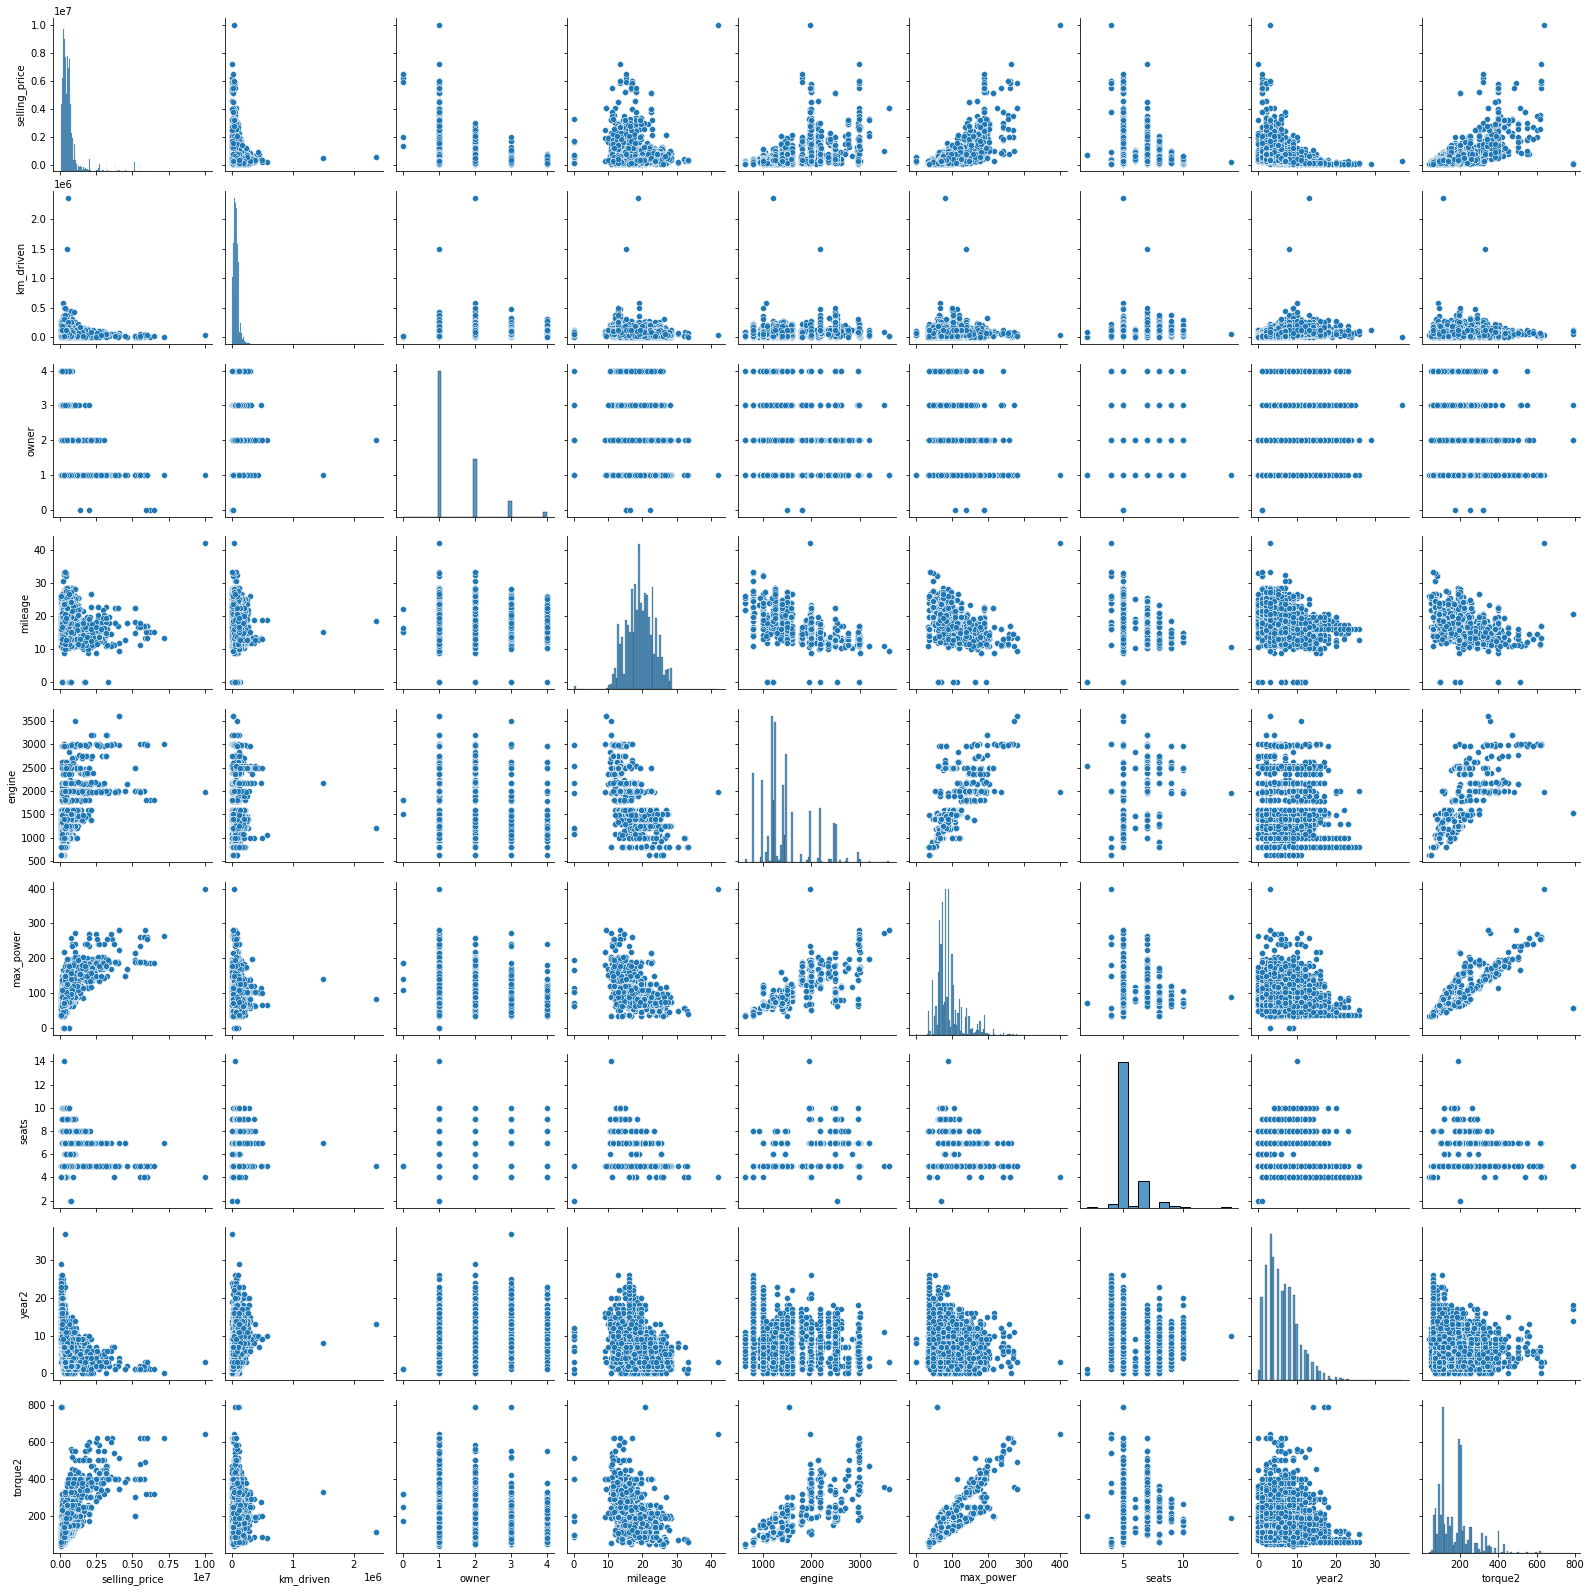

In [15]:
ax = sns.pairplot(data)

- Not all predictors have a linear relationship with the target variable
- I assume that the brand and model will affect the value
- Zero mileage and zero max_power looks bad
- km_driver more than 300k km looks like outliars.
- mileage more than 35 looks like outliars.
- 789nm looks like a bug

<a id="eda.dt2"></a>
### Data transformation. Stage 2

#### Brand and model

In [16]:
def brand_parser(x):
    try:
        parsed = re.findall(r"^(\S*)\s(\S*)", x, re.IGNORECASE)[0]
    except Exception as e:
        parsed = ["unparsed", "value"]
    finally:
        return parsed[0] + " " + parsed[1]
    
data["brand_model"] = data["name"].apply(brand_parser)

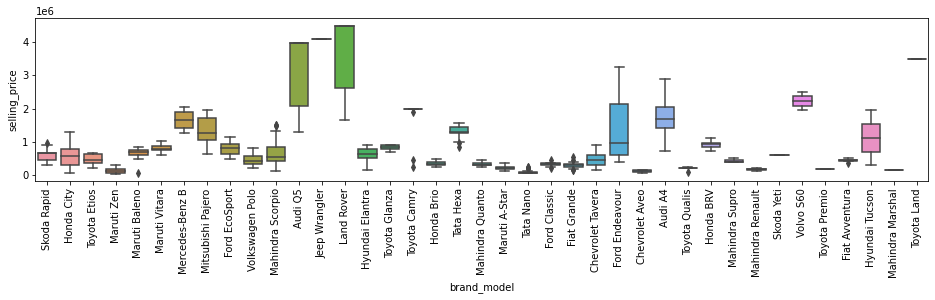

In [17]:
fig, ax = plt.subplots(figsize=(16,3))

vals, cnts = np.unique(data["brand_model"], return_counts=True)
idxs = np.argsort(-cnts)

models = np.random.choice(vals, 40)
df = data[data["brand_model"].isin(models)]
ax = sns.boxplot(x=df["brand_model"], y=df["selling_price"], ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

<a id="eda.na"></a>
### Deal with NA

Fill in the missing values with the average for each brand_model

In [18]:
data["mileage"] = data.groupby("brand_model").transform(lambda x: x.fillna(x.mean()))["mileage"]
data["engine"] = data.groupby("brand_model").transform(lambda x: x.fillna(x.mean()))["engine"]
data["max_power"] = data.groupby("brand_model").transform(lambda x: x.fillna(x.mean()))["max_power"]
data["seats"] = data.groupby("brand_model").transform(lambda x: x.fillna(np.round(x.mean())))["seats"]
data["torque2"] = data.groupby("brand_model").transform(lambda x: x.fillna(x.mean()))["torque2"]

In [19]:
na_count = data.isna().any(axis=1).sum()
print("Records with NA values: %s" % na_count)
data = data.dropna()

Records with NA values: 21


<a id="eda.dt3"></a>
### Data transformation. Stage 3

#### Drop bad values

In [20]:
data = data[data["mileage"]>0]
data = data[data["max_power"]>0]

#### Target variable

In [21]:
data["selling_price2"] = np.log(data["selling_price"])
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

#### km_driver

In [54]:
# km_driver more than 300k km looks like outliars. От греха подальше...
data = data[data["km_driven"]<300000]

#### mileage

In [55]:
# mileage more than 35 looks like outliars. Туда же.
data = data[data["mileage"]<35]

#### Torque  values

In [56]:
# "Maruti Zen D" torque looks like a mistake. It isn't 789nm, but 78nm. Хотел бы я 790 Нм, но нет.
data.loc[data["name"]=="Maruti Zen D", "torque2"] = 78
# this will make the relationship between torque2 and target variable more linear 
data["torque2"] = np.log(data["torque2"])

#### Other mistakes

In [25]:
# Fix some mistakes
data.loc[data["brand_model"]=="Honda BRV", "brand_model"] = "Honda BR-V"
data.loc[data["brand_model"]=="Ford Ecosport", "brand_model"] = "Ford EcoSport"
data.loc[data["brand_model"]=="Ambassador CLASSIC", "brand_model"] = "Ambassador Classic"

<a id="eda.fpp"></a>
### And final pairplot...

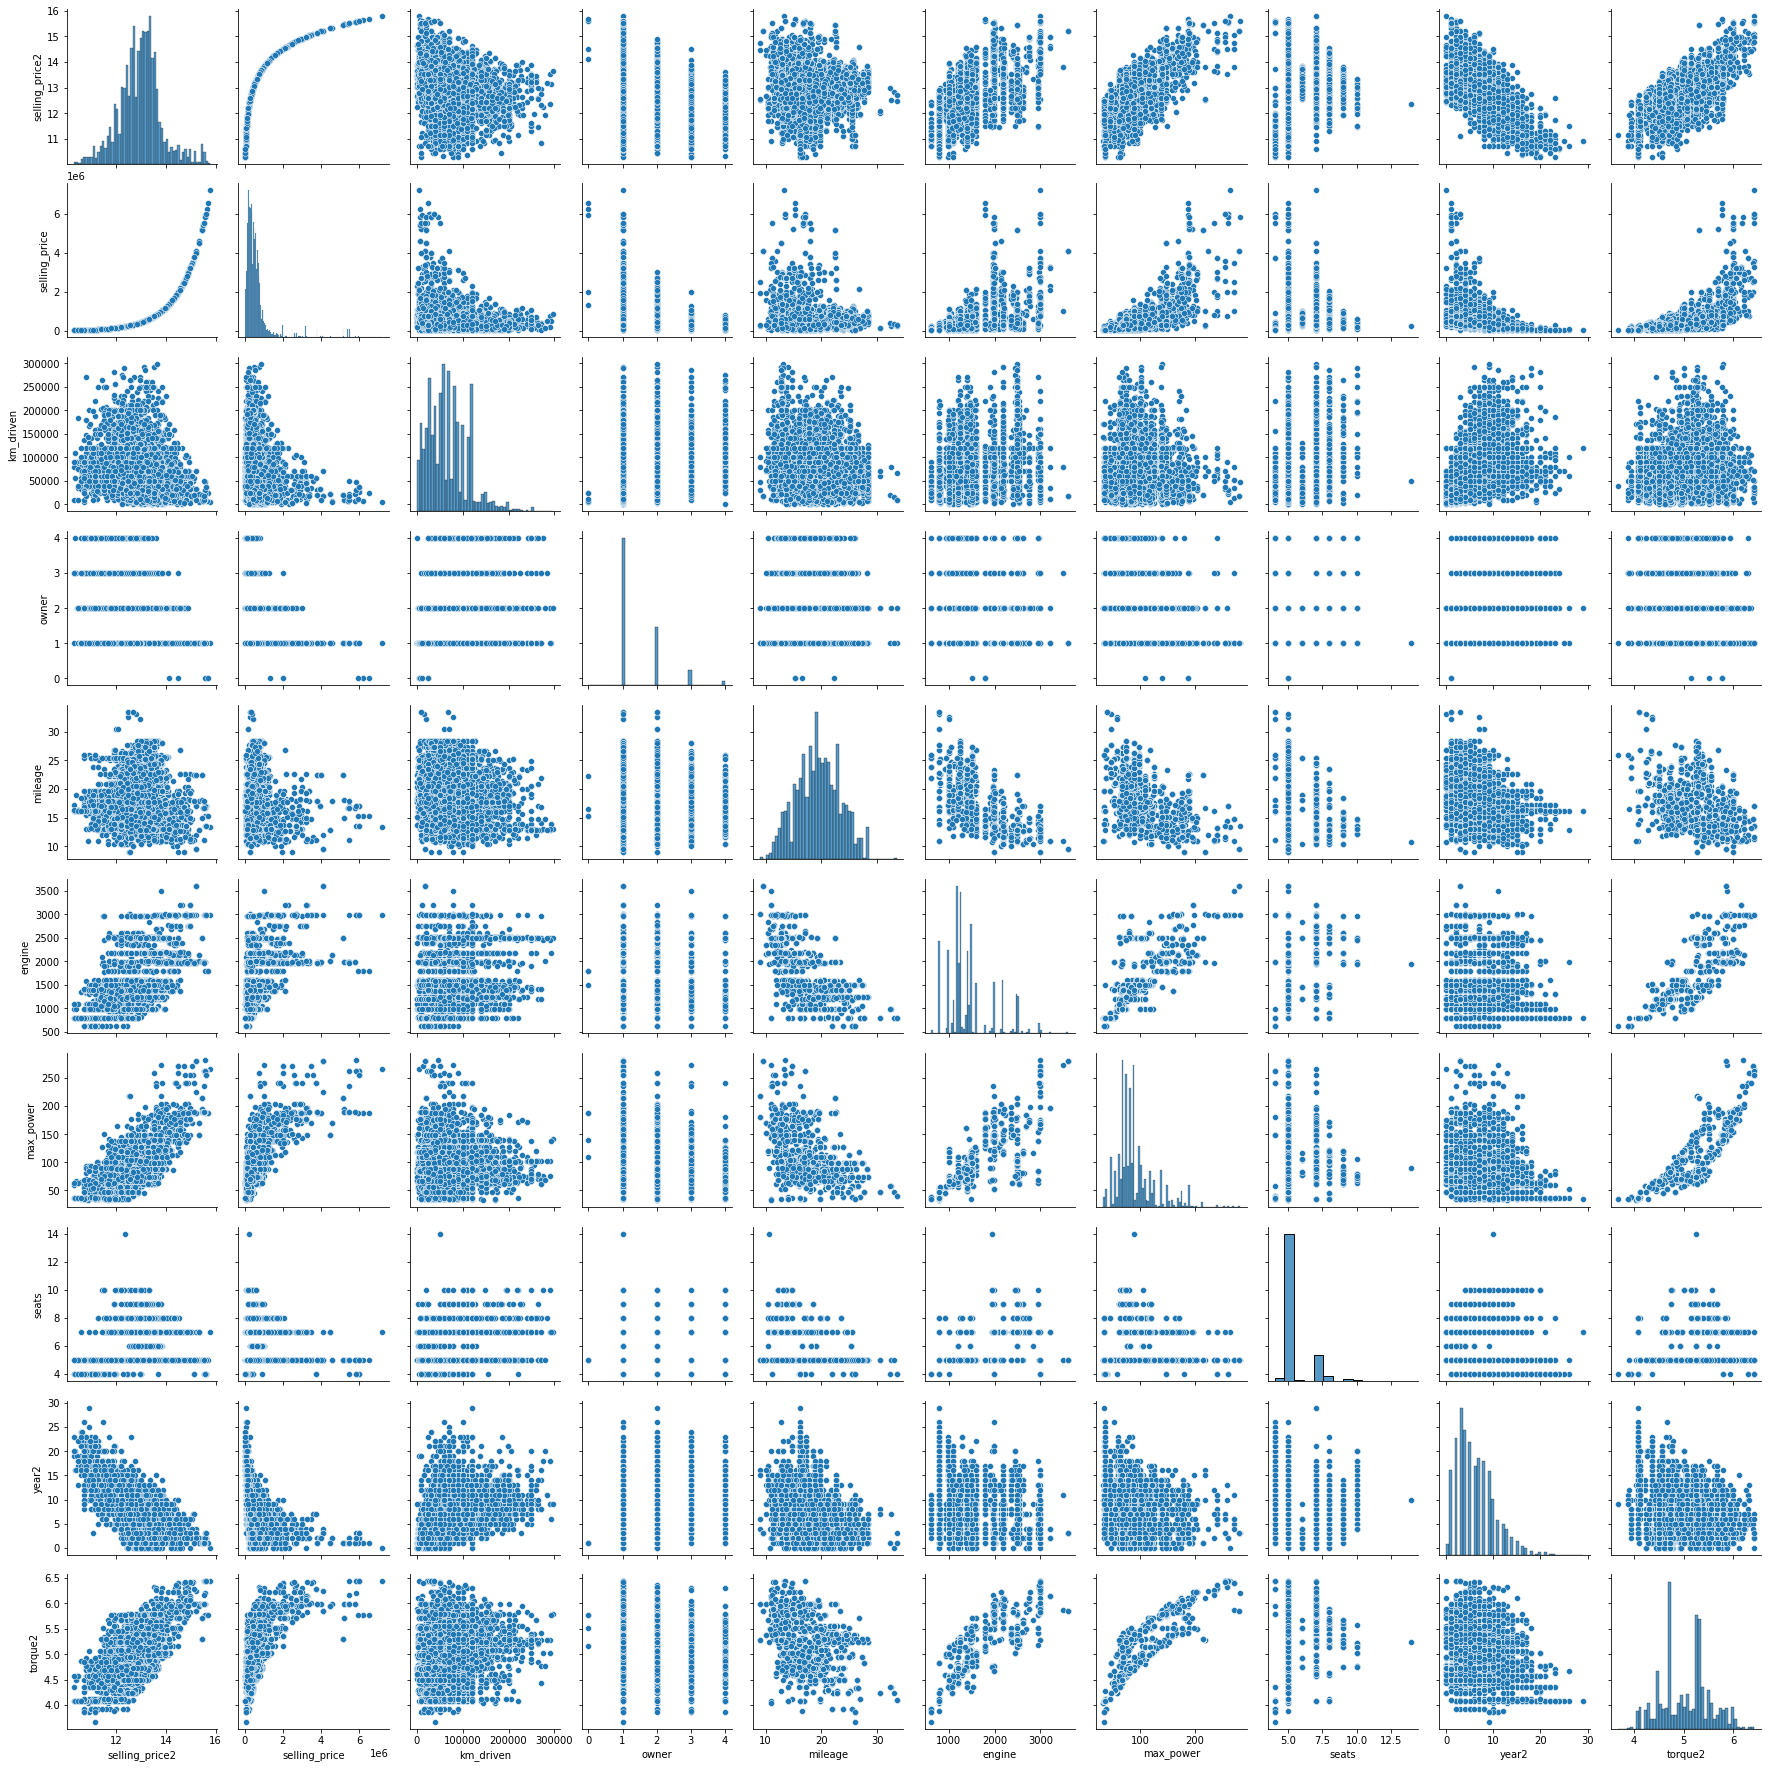

In [26]:
ax = sns.pairplot(data)

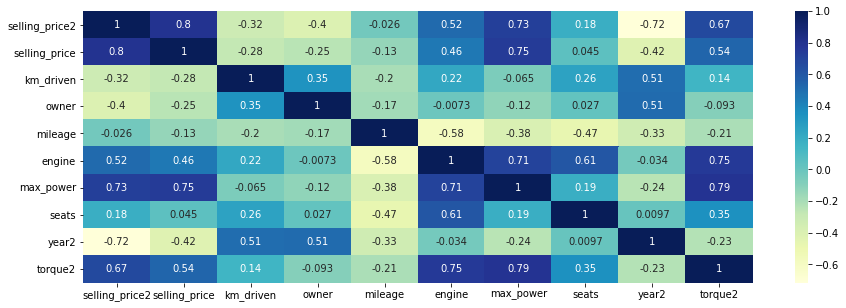

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
corr = data.corr()
ax = sns.heatmap(corr, annot=True, ax=ax, cmap="YlGnBu")

<a id="eda.c"></a>
## Conclusion 
1. The distribution of the target variable appears to be normal. This does not linear regression assume, but in this case it improves the result.
2. Removed explicit outliers and corrected data errors
3. The dependence of predictors with target variable appears to be linear
4. Correlation matrix does not show strong linear relationship between predictors

In [28]:
data = data.drop(["selling_price"], axis=1)
data_cleared = data.copy()

In [29]:
data = data_cleared.copy()

<a id="lr"></a>
# Linear regression model

<a id="lr.ds"></a>
## Dataset

In [30]:
data_lr = data.copy()

y = data_lr["selling_price2"]
X = data_lr.drop(["name", "selling_price2"], axis=1)

X = pd.get_dummies(X, columns=["fuel", "seller_type", "transmission", "owner", "seats", "brand_model"])

display(X.shape)
display(X.head(2))

(8056, 223)

,km_driven,mileage,engine,max_power,year2,torque2,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_0,owner_1,owner_2,owner_3,owner_4,seats_4.0,seats_5.0,seats_6.0,seats_7.0,seats_8.0,seats_9.0,seats_10.0,seats_14.0,brand_model_Ambassador Classic,brand_model_Ambassador Grand,brand_model_Ashok Leyland,brand_model_Audi A3,brand_model_Audi A4,brand_model_Audi A6,brand_model_Audi Q3,brand_model_Audi Q5,brand_model_Audi Q7,brand_model_BMW 3,brand_model_BMW 5,brand_model_BMW 6,brand_model_BMW 7,brand_model_BMW X1,brand_model_BMW X3,brand_model_BMW X4,brand_model_BMW X5,brand_model_BMW X6,brand_model_BMW X7,brand_model_Chevrolet Aveo,brand_model_Chevrolet Beat,brand_model_Chevrolet Captiva,...,brand_model_Renault Scala,brand_model_Renault Triber,brand_model_Skoda Fabia,brand_model_Skoda Kodiaq,brand_model_Skoda Laura,brand_model_Skoda Octavia,brand_model_Skoda Rapid,brand_model_Skoda Superb,brand_model_Skoda Yeti,brand_model_Tata Aria,brand_model_Tata Bolt,brand_model_Tata Harrier,brand_model_Tata Hexa,brand_model_Tata Indica,brand_model_Tata Indigo,brand_model_Tata Manza,brand_model_Tata Nano,brand_model_Tata New,brand_model_Tata Nexon,brand_model_Tata Safari,brand_model_Tata Spacio,brand_model_Tata Sumo,brand_model_Tata Tiago,brand_model_Tata Tigor,brand_model_Tata Venture,brand_model_Tata Winger,brand_model_Tata Xenon,brand_model_Tata Zest,brand_model_Toyota Camry,brand_model_Toyota Corolla,brand_model_Toyota Etios,brand_model_Toyota Fortuner,brand_model_Toyota Glanza,brand_model_Toyota Innova,brand_model_Toyota Land,brand_model_Toyota Platinum,brand_model_Toyota Qualis,brand_model_Toyota Yaris,brand_model_Volkswagen Ameo,brand_model_Volkswagen CrossPolo,brand_model_Volkswagen GTI,brand_model_Volkswagen Jetta,brand_model_Volkswagen Passat,brand_model_Volkswagen Polo,brand_model_Volkswagen Vento,brand_model_Volvo S60,brand_model_Volvo S90,brand_model_Volvo V40,brand_model_Volvo XC40,brand_model_Volvo XC60
0,145500,23.40,1248.0,74.00,6,5.247024,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,120000,21.14,1498.0,103.52,6,5.521461,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<a id="lr.ra"></a>
## Regression analysis

In [32]:
X_ = sm.add_constant(X)
model_ols = sm.OLS(y, X_).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         selling_price2   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     635.0
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:00:33   Log-Likelihood:                 1750.3
No. Observations:                8056   AIC:                            -3067.
Df Residuals:                    7839   BIC:                            -1549.
Df Model:                         216                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

MSE: 0.037915322590589204
R^2: 0.9459350957786419
Residuals mean: 3.972714466783205e-12
Distribution is not normal. Statistic: 0.334, p-value: 0.0


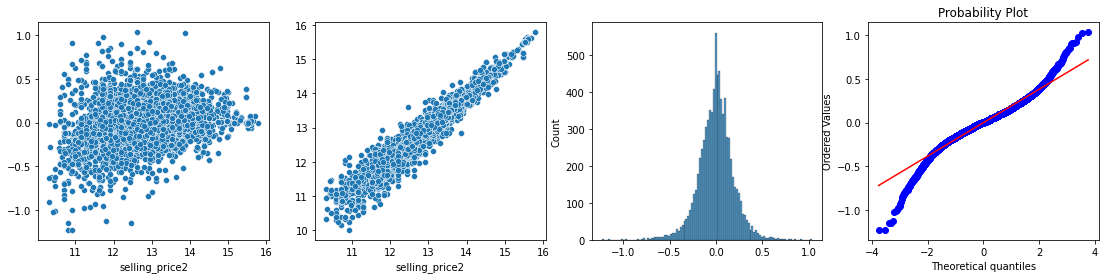

In [33]:
y_pred = model_ols.predict(X_)
validate(y, y_pred)

This model explains 94.6% of the variation in the dependent variable, while the MSE was 0.038.

When diagnosing the model, 2 problems were identified:
 - Abnormal distribution of residuals
 - Signs of heteroscedasticity
 
Violating the linear regression assumptions can result in the trained model not being optimal for a given dataset.
Also, if the assumption about the random distribution of residuals is violated, we cannot reliably use statistical tests to determine the significance of the predictor.

Violations of linear regression assumptions may be due to outliers, non-linear relationships, or the absence of a predictor.

Looking ahead, I will say that the transformation of predictors did not lead to an increase in the accuracy of the model.

Let's try to identify and remove outliers.

In [34]:
influence = model_ols.get_influence()
(c, p) = influence.cooks_distance
    
distances = pd.DataFrame(c, index=X.index)
distances = distances.fillna(1)

/Users/alex/opt/anaconda3/envs/poloniexapi/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/alex/opt/anaconda3/envs/poloniexapi/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


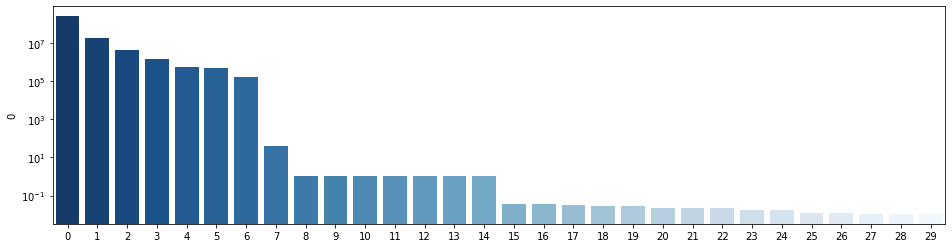

In [35]:
n_max = 30
max_values = distances.nlargest(n_max, columns=0)[0]

fig, ax = plt.subplots(figsize=(16, 4))
ax.set_yscale("log")
ax = sns.barplot(y=max_values, x=np.arange(n_max), ax=ax, palette="Blues_r")

In [36]:
X = X.drop(max_values.index)
y = y.drop(max_values.index)

In [37]:
X_ = sm.add_constant(X)
model_ols2 = sm.OLS(y, X_).fit()
print(model_ols2.summary())


                            OLS Regression Results                            
Dep. Variable:         selling_price2   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     699.4
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:02:57   Log-Likelihood:                 1814.2
No. Observations:                8026   AIC:                            -3230.
Df Residuals:                    7827   BIC:                            -1839.
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

MSE: 0.03735229525935657
R^2: 0.9463658716280925
Residuals mean: 0.0002266706467313375
Distribution is not normal. Statistic: 0.334, p-value: 0.0


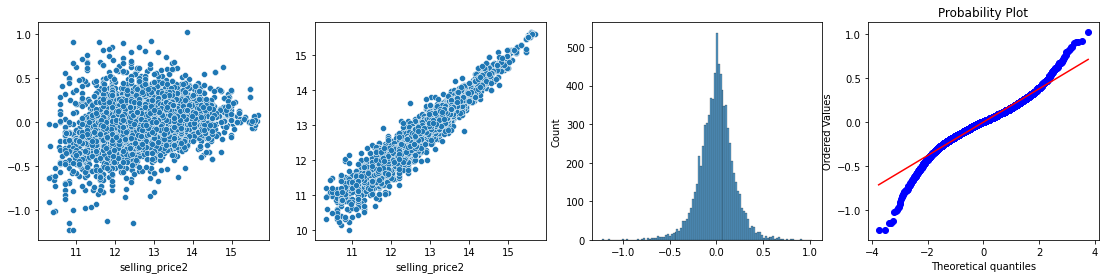

In [38]:
y_pred = model_ols.predict(X_)
validate(y, y_pred)

<a id="lr.c"></a>
### Conclusion

Deleting points with great influence allowed to slightly improve performance, but the model has not changed fundamentally.

Let's build a regression model taking into account the identified problems.

I will assume that hetetoscedasticity may be due to the absence of a predictor. For example, the equipment of the car, which affects the cost.

<a id="lr.rr"></a>
## Ridge regression

In [39]:
scaler = StandardScaler()
X_sc = pd.DataFrame(scaler.fit_transform(X), index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.33, random_state=random_state)

In [40]:
def hyperopt(X, y, params):
    try:
        model = Ridge(**params, normalize=False)
        score = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
        return -score.mean()
    
    except Exception as ex :
        print(ex)
        return np.inf

def f_model(params):
    global best
    global best_params
    acc = hyperopt(X_train, y_train, params)
    if (acc < best):
        best = acc
        best_params = params
        print("new best: {0:.7} {1}".format(best, params))
    return {'loss': acc, 'status': STATUS_OK}


def model_tune(space, random_state=random_state, iters=10):
    global best
    global best_params
    best, best_params = np.inf, None 
    res = fmin(f_model, space, algo=tpe.suggest, max_evals=iters, rstate=np.random.RandomState(random_state))
    model = Ridge(random_state=random_state, **best_params, normalize=False)
    print("\nBest_params: \n", best_params)
    return model


space_l = {
    'alpha': hp.uniform('alpha', 0.00001, 2),
    'tol': hp.uniform('tol', 0.000001, 0.5),
}

In [41]:
model_reg = model_tune(space_l, iters=30)

new best: 0.04191108 {'alpha': 1.608093991388026, 'tol': 0.04621422879635726}
new best: 0.04190577 {'alpha': 1.890002862290762, 'tol': 0.4284735534742241}     
new best: 0.04190381 {'alpha': 1.9951530577889802, 'tol': 0.2444510806134035}     
new best: 0.04190376 {'alpha': 1.9974966466114068, 'tol': 0.31291266215824354}    
100%|██████████| 30/30 [00:10<00:00,  2.96trial/s, best loss: 0.04190376287747414]

Best_params: 
 {'alpha': 1.9974966466114068, 'tol': 0.31291266215824354}


In [42]:
model_reg = model_reg.fit(X_train, y_train)

MSE: 0.04199468542182033
R^2: 0.9371475066657923
Residuals mean: 0.004843989335448784
Distribution is not normal. Statistic: 0.331, p-value: 7.904e-259


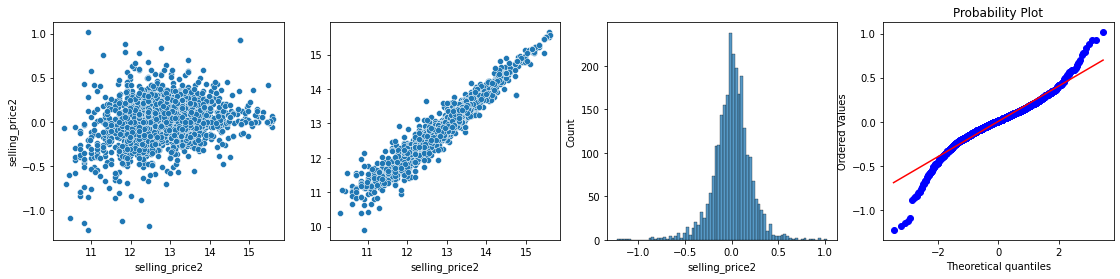

In [43]:
y_pred = model_reg.predict(X_test)
validate(y_test, y_pred)

<a id="lr.rrc"></a>
### Conclusion

The model is built, the previously mentioned problems are observed - the non-normality of the distribution of the residuals and the signs of heteroscedasticity.

The MSE value is 0.042. But the average of the errors is close to zero.

<a id="xgb"></a>
# XGBOOST

For comparison, let's build a XGBoost model.

<a id="xgb.ds"></a>
## Dataset

In [48]:
data_xgb = data.copy()

y = data_xgb["selling_price2"].copy()
X = data_xgb.drop(["name", "selling_price2"], axis=1).copy()

X = pd.get_dummies(X, columns=["fuel", "seller_type", "seats", "transmission", "brand_model"], drop_first=True)

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index)

display(X.head(3))
display(y.head(3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213
0,0.488253,0.25,0.589198,0.209396,0.165329,0.206897,0.571541,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.402683,0.50,0.496727,0.293289,0.283788,0.206897,0.670962,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.469797,0.75,0.355974,0.292953,0.181380,0.482759,0.397998,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    13.017003
1    12.821258
2    11.970350
Name: selling_price2, dtype: float64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<a id="xgb.m"></a>
## Model

In [52]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1, 
                          max_depth = 10, 
                          alpha = 1, 
                          n_estimators = 250)

xg_reg = xg_reg.fit(X_train,y_train)


MSE: 0.040029149558673566
R^2: 0.9441257377586075
Residuals mean: 0.0016418055151169273
Distribution is not normal. Statistic: 0.328, p-value: 8.268e-256


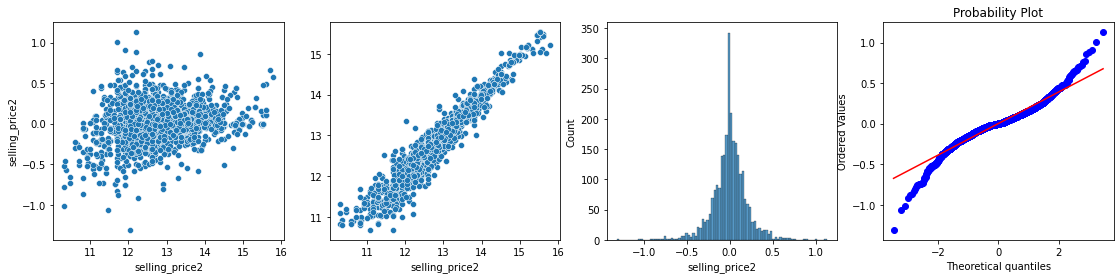

In [53]:
y_pred = xg_reg.predict(X_test)
validate(y_test, y_pred)

<a id="conclusion"></a>
# Conclusion

In this solution the following steps were taken


1. Data understanding and preparing
    - Removed outliers and erroneous values
    - Parsed text values
    - Filled missing values
    - Features are transformed
2. Performing regression analysis
    - Evaluated the fulfillment of the linear regression assumptions
    - Removed outliers based on Cook's distance
3. Fitted a linear regression model. Optimal parameters are configured via HyperOpt.
4. Fitted a comparative model based on XGBoost.

The linear regression model showed 2 problems - the residuals are not normally distributed, and heteroscedasticity is also observed.
I will assume that the reasons lie in the absence of an important predictor. When using such a model, it should be borne in mind that it may not be optimal for the given task/dataset.

In addition, I note that the accuracy of linear regression almost coincided with the accuracy of the model based on XGBoost. It seems that it is difficult to achieve a better result on the current data.

Thanks for attention!